# U-Net的医学图像分割实验

本实验使用U-Net网络实现医学图像分割任务，使用的数据来自Kaggle的公开数据集。结合课程学习，通过本实验可以了解U-Net网络结构和数据处理相关知识，并通过MindSpore深度学习框架实现。

## 1. 基于U-Net的医学图像分割实验简介

### 1.1 医学图像分割概念

根据医学图像的某种相似性特征将医学图像划分为若干个互不相交的“连通”的区域的过程。如下图所示：

+ a为“PhC-U373”数据集的输入图像的一部分

+ b为分割结果

<div align="center">
<img src="./images/06.png" width="50%" height="50%">
</div>

### 1.2 目前分割主要存在问题

使用深度学习进行图像分割，采用了分类的思路，对每个像素点进行分类，判断像素点是属于目标前景还是背景。

传统卷积神经网络做分类的步骤是：

+ 单个图像经过多层卷积得到降维之后的特征图

+ 特征图经过全连接层变成一个分类器

+ 输出一个类别的向量，这就是分类的结果

对于基于神经网络的图像分割问题来说，图像中的每一个像素都会输出一个分类结果，传统神经网络中分类的向量，就变成了一个分类的特征图，通道数等于类别数量。

分割网络中的池化操作在减少feature的空间分辨率的同时增加了模型感受野，这也是模型应对小型平移具有鲁棒性的根本原因。但是连续的下采样得到的feature map 就会丢失一些low-level中关键信息(例如边沿，边界等)。这就让识别和准确定位产生了矛盾。如果网络不采取任何池化操作，这在目标边界定位上效果较好，但是识别性能差。

为了解决这个问题，U-net采用多个skip-connection将底层的feature和高层的feature concat，U-Net结构如下图。每个蓝色框对应一个多通道特征图。通道数显示在框的顶部。 x-y 尺寸位于框的左下边缘。白框代表复制的特征图。箭头表示不同的操作。

<div align="center">
<img src="./images/01.png" width="50%" height="50%">
</div>

[U-Net论文链接](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

### 1.3 文章主要观点

+ U-Net建立在FCN的网络架构上，作者在网络框架上改进，使其能够使用很少的训练图像就得到很精确的分割结果。

+ 添加连续**upsample**阶段，并且channel维度增大，在decoder部分concat进入更多的原图像纹理的信息。

+ U-Net没有FC层，卷积层的数量大约在20个左右，4次下采样，4次上采样。

## 2. U-Net医学图像分割实验

### 2.1 导入实验环境

运行下面代码，在下拉菜单中选择实验环境，目前支持CPU和Ascend NPU切换。

In [1]:
import os
import mindspore
from mindspore import Model, context
import ipywidgets as wgs # 控件，请安装ipywidgets==7.7.1

dropdown = wgs.Dropdown(description="Select Device", options=['Click to choose', 'CPU', 'Ascend NPU'])
output = wgs.Output()
def changeDevice(change):
    output.clear_output()
    #device_id = 2
    token = change.new
    with output:
        if token == 'Click to choose':
            print("请选择运行环境")
        if token == 'CPU':
            print("请确认当前环境为CPU\n======================================================================")
            try:
                context.set_context(mode=context.GRAPH_MODE, device_target="CPU", save_graphs=False)
                print("已检查！确认当前环境为CPU")
            except ValueError:
                print("错误！当前是系统硬件不是CPU，请重新选择合适的硬件设备")
        if token == 'Ascend NPU':
            print("请确认当前环境为Ascend NPU\n===============================================================")
            try:
                context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", save_graphs=False)
                print("当前环境为Ascend NPU")
            except ValueError:
                print("错误！当前是系统硬件不是Ascend NPU，请重新选择合适的硬件设备")


dropdown.observe(changeDevice, names='value')
display(dropdown, output)

Dropdown(description='Select Device', options=('Click to choose', 'CPU', 'Ascend NPU'), value='Click to choose…

Output()

运行下面代码进行当前实验环境环境配置

In [2]:
mindspore.set_seed(1)
if dropdown.value == 'CPU':
    print("选择的环境是：" + dropdown.value)
    device_id = 2
    try:
        context.set_context(mode=context.GRAPH_MODE, device_target="CPU", save_graphs=False)
        print("CPU环境设置成功！")
    except ValueError:
        print("错误！当前是系统硬件不支持CPU，请返回上一步重新选择合适的硬件设备")
    epochs = 2
    resume = True
    per_print_times = 1
    resume_ckpt = './checkpoints/pretrained.ckpt'
elif dropdown.value == 'Ascend NPU':
    print("选择的环境是：" + dropdown.value)
    device_id = 2
    try:
        context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", save_graphs=False)
        print("Ascend NPU环境设置成功！")
    except ValueError:
        print("错误！当前是系统硬件不支持Asend NPU，请返回上一步重新选择合适的硬件设备")
    epochs = 400
    resume = False
    per_print_times = 60
    resume_ckpt = './'
elif dropdown.value == 'Click to chose':
    print("未手动选择运行环境")
    device_id = 2
    try:
        context.set_context(mode=context.GRAPH_MODE, device_target="CPU", save_graphs=False)
        print("默认运行为CPU环境，已设置成功！")
    except ValueError:
        print("错误！当前是系统硬件不支持CPU，请返回上一步重新选择合适的硬件设备")
    epochs = 2
    resume = True
    per_print_times = 1
    resume_ckpt = './checkpoints/pretrained.ckpt'
else:
    print("未手动选择运行环境")
    device_id = 2
    try:
        context.set_context(mode=context.GRAPH_MODE, device_target="CPU", save_graphs=False)
        print("默认运行为CPU环境，已设置成功！")
    except ValueError:
        print("错误！当前是系统硬件不支持CPU，请返回上一步重新选择合适的硬件设备")
    epochs = 2
    resume = True
    per_print_times = 1
    resume_ckpt = './checkpoints/pretrained.ckpt'

选择的环境是：CPU
CPU环境设置成功！


### 2.2 实验数据集

本实验所用数据集来自Kaggle官网的公开数据集[LGG Segmentation Dataset](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/code )。该数据集包含大脑 MR 图像以及手动 FLAIR 异常分割掩码，大小为1.06GB。
训练和测试数据集为Kaggle公开数据集。处理后的数据集大小为20 MB，共四个文件：volume.tif，labels.tif，test.tif，testlabel.tif。

+ 第一个文件为训练集图像，该TIF文件共有30个通道，每个通道为一张灰度图像。

+ 第二个文件为训练集标签，该TIF文件共有30个通道，每个通道为一张灰度图像（像素值仅为0或255）。

+ 第三个文件为测试集图像，该TIF文件有10个通道，每个通道为一张灰度图像。

+ 第四个文件为测试集标签，该TIF文件共有10个通道，每个通道为一张灰度图像（像素值仅为0或255）。

#### 2.2.1 数据集可视化

##### 加载数据集

运行下面代码将数据集下载并解压在notebook所在目录下的dataset文件夹下。

In [3]:
import os
import requests
import time
import zipfile

# 自动下载并解压数据集到指定文件夹内
def download_and_unzip(url, path):
    if not os.path.exists(path):   # 看是否有该文件夹，没有则创建文件夹
        os.mkdir(path)
    file_path = os.path.join(path, 'case7BrainMRI.zip')
    start = time.time() #下载开始时间
    user, password = 'tyx_neu', 'Sportlab307'
    resp = requests.get(url, auth=(user, password), stream=True)      #把下载地址发送给requests模块
    size = 0    #初始化已下载大小
    chunk_size = 1024  # 每次下载的数据大小
    content_size = int(resp.headers['content-length'])  # 下载文件总大小
    try:
        if resp.status_code == 200:   #判断是否响应成功
            print('Start download,[File size]:{size:.2f} MB'.format(size=content_size/chunk_size/1024))  #开始下载，显示下载文件大小
            with open(file_path, 'wb') as file:   #显示进度条
                for data in resp.iter_content(chunk_size=chunk_size):
                    file.write(data)
                    size += len(data)
                    print('\r'+'[下载进度]:%s%.2f%%' % ('>'*int(size*50/content_size), float(size/content_size*100)), end=' ')
        end = time.time()   #下载结束时间
        print('\n'+'Download completed!,times: %.2f秒' % (end - start))  #输出下载用时时间
    except ValueError:
        print('Error!')
    unzip_file_path = os.path.join(path, 'case7BrainMRI')
    if not os.path.exists(unzip_file_path):   # 看是否有该文件夹，没有则创建文件夹
        os.mkdir(unzip_file_path)
    zip_file = zipfile.ZipFile(file_path)
    zip_list = zip_file.namelist()  # 压缩文件清单，可以直接看到压缩包内的各个文件的明细
    for f in zip_list:  # 遍历这些文件，逐个解压出来，
        zip_file.extract(f, unzip_file_path)
    zip_file.close()
    print('Successfully unzip download dataset from website!')

#下载地址
url = 'https://openi.pcl.ac.cn/attachments/e8ac2afb-e189-47aa-b916-f0be50b737a8?type=1'
download_and_unzip(url, os.path.join(os.getcwd(), 'dataset'))

Start download,[File size]:3.84 MB
[下载进度]:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00% 
Download completed!,times: 3.86秒
Successfully unzip download dataset from website!


##### 可视化

选取训练集图像和训练集标签的图片进行可视化，如下图所示：左图为MRI图像，右图为对应的标签图像，空白部分为分割出的病变部位。

(30, 512, 512)
(30, 512, 512)


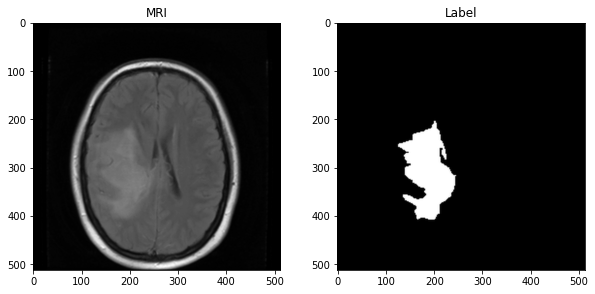

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageSequence

# 数据集路径
data_url = './dataset/case7BrainMRI/case7/BrainMRI/train'

#打印图像和标签的形状，并展示第一张图像和标签
image = np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(data_url + r"/volume.tif"))])

label = np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(data_url + r"/labels.tif"))])

print(image.shape)
print(label.shape)
#设置图像大小，单位为“英寸”
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title('MRI')
plt.imshow(image[20], cmap='gray')
plt.subplot(2, 2, 2)
plt.title('Label')
plt.imshow(label[20], cmap='gray')
plt.show()

#### 2.2.2 数据预处理

在深度学习项目中，数据的收集和处理会花费相当多的时间。但在很多实际的项目中特别是医学图像，数据的获取和标注成本是很高的，我们难以找到充足的数据来完成任务。为了防止深度学习模型出现严重的过拟合现象，当数据量不足时，我们通常会做数据增强，扩大数据集样本量，提升数据样本空间的复杂度。

在本实验中，使用普通的**仿射变换**（即翻转，旋转，裁剪）和改变亮度来达到数据增强的目的。

此外，由于U-Net网络的输入是大于输出的，因此，在输入图像前，我们还需要对原图进行放大。如下图，实际预测的区域为黄色的区域（输出层对应的区域），实际输入的区域为蓝色的区域。左图中间白色线框为训练集中的原图，外面一圈是通过对边缘部分进行翻转，旋转变换得到的。

<div align="center">
<img src="./images/02.png" width="50%" height="50%">
</div>

##### 加载数据集

定义加载数据集的函数。以下为代码实现：

In [5]:
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as c_vision
from mindspore.dataset.vision.utils import Inter
from collections import deque

def _load_multipage_tiff(path):
    """Load tiff images containing many images in the channel dimension"""
    return np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(path))])

##### 打乱和切分

接下来将训练数据分为训练集和验证集，需要对数据进行打乱和切分。以下为打乱和切分代码实现：

In [6]:
def _get_val_train_indices(length, fold, ratio=0.8):
#将训练数据分为训练集和验证集
    assert 0 < ratio <= 1, "Train/total data ratio must be in range (0.0, 1.0]"
    np.random.seed(0)
    indices = np.arange(0, length, 1, dtype=int)
    #打乱数据，利于模型训练
    np.random.shuffle(indices)

    if fold is not None:
        #使用deque方式切分数据
        indices = deque(indices)
        indices.rotate(fold * round((1.0 - ratio) * length))
        indices = np.array(indices)
        train_indices = indices[:round(ratio * len(indices))]
        val_indices = indices[round(ratio * len(indices)):]
    else:
        train_indices = indices
        val_indices = []
    return train_indices, val_indices
def data_post_process(img, mask):

    img = np.expand_dims(img, axis=0)
    mask = (mask > 0.5).astype(int)
    mask = (np.arange(mask.max() + 1) == mask[..., None]).astype(int)
    mask = mask.transpose(2, 0, 1).astype(np.float32)
    return img, mask

##### 数据增强

对数据进行旋转、翻转裁剪和亮度调节操作，优化模型的训练效果。以下为数据增强代码实现：

In [7]:
def train_data_augmentation(img, mask):
#原数据只有30张训练数据，因此需要数据增强
    #生成随机数，如果随机数大于0.5就旋转图像。
    h_flip = np.random.random()
    if h_flip > 0.5:
        img = np.flipud(img)
        mask = np.flipud(mask)
    #生成随机数，如果随机数大于0.5就翻转图像。
    v_flip = np.random.random()
    if v_flip > 0.5:
        img = np.fliplr(img)
        mask = np.fliplr(mask)
    #生成随机数用于裁剪图像
    left = int(np.random.uniform()*0.3*572)
    right = int((1-np.random.uniform()*0.3)*572)
    top = int(np.random.uniform()*0.3*572)
    bottom = int((1-np.random.uniform()*0.3)*572)

    #裁剪
    img = img[top:bottom, left:right]
    mask = mask[top:bottom, left:right]

    #改变亮度
    brightness = np.random.uniform(-0.2, 0.2)
    img = np.float32(img+brightness*np.ones(img.shape))
    img = np.clip(img, -1.0, 1.0)

    return img, mask

#### 2.2.3 数据集加载

加载volume.tif、labels.tif，按照8:2划分为训练集和验证集，生成train_ds、valid_ds两个数据集。具体实现代码如下：

In [8]:
def create_dataset(data_dir, repeat=200, train_batch_size=16, augment=False, cross_val_ind=1, run_distribute=False):
#创建数据集
    images = _load_multipage_tiff(os.path.join(data_dir, "train/volume.tif"))
    masks = _load_multipage_tiff(os.path.join(data_dir, "train/labels.tif"))
    # images = _load_multipage_tiff(os.path.join(data_dir, "volume.tif"))
    # masks = _load_multipage_tiff(os.path.join(data_dir, "labels.tif"))
    train_indices, val_indices = _get_val_train_indices(len(images), cross_val_ind)
    train_images = images[train_indices]
    train_masks = masks[train_indices]
    train_images = np.repeat(train_images, repeat, axis=0)
    train_masks = np.repeat(train_masks, repeat, axis=0)
    val_images = images[val_indices]
    val_masks = masks[val_indices]

    train_image_data = {"image": train_images}
    train_mask_data = {"mask": train_masks}
    valid_image_data = {"image": val_images}
    valid_mask_data = {"mask": val_masks}


    ds_train_images = ds.NumpySlicesDataset(data=train_image_data, sampler=None, shuffle=False)
    ds_train_masks = ds.NumpySlicesDataset(data=train_mask_data, sampler=None, shuffle=False)

    ds_valid_images = ds.NumpySlicesDataset(data=valid_image_data, sampler=None, shuffle=False)
    ds_valid_masks = ds.NumpySlicesDataset(data=valid_mask_data, sampler=None, shuffle=False)

    c_resize_op = c_vision.Resize(size=(388, 388), interpolation=Inter.BILINEAR)
    c_pad = c_vision.Pad(padding=92)
    c_rescale_image = c_vision.Rescale(1.0/127.5, -1)
    c_rescale_mask = c_vision.Rescale(1.0/255.0, 0)

    c_trans_normalize_img = [c_rescale_image, c_resize_op, c_pad]
    c_trans_normalize_mask = [c_rescale_mask, c_resize_op, c_pad]
    c_center_crop = c_vision.CenterCrop(size=388)

    train_image_ds = ds_train_images.map(input_columns="image", operations=c_trans_normalize_img)
    train_mask_ds = ds_train_masks.map(input_columns="mask", operations=c_trans_normalize_mask)
    train_ds = ds.zip((train_image_ds, train_mask_ds))
    train_ds = train_ds.project(columns=["image", "mask"])
    if augment:
        augment_process = train_data_augmentation
        c_resize_op = c_vision.Resize(size=(572, 572), interpolation=Inter.BILINEAR)
        train_ds = train_ds.map(input_columns=["image", "mask"], operations=augment_process)
        train_ds = train_ds.map(input_columns="image", operations=c_resize_op)
        train_ds = train_ds.map(input_columns="mask", operations=c_resize_op)

    train_ds = train_ds.map(input_columns="mask", operations=c_center_crop)
    post_process = data_post_process
    train_ds = train_ds.map(input_columns=["image", "mask"], operations=post_process)
    train_ds = train_ds.shuffle(repeat*24)
    train_ds = train_ds.batch(batch_size=train_batch_size, drop_remainder=True)

    valid_image_ds = ds_valid_images.map(input_columns="image", operations=c_trans_normalize_img)
    valid_mask_ds = ds_valid_masks.map(input_columns="mask", operations=c_trans_normalize_mask)
    valid_ds = ds.zip((valid_image_ds, valid_mask_ds))
    valid_ds = valid_ds.project(columns=["image", "mask"])
    valid_ds = valid_ds.map(input_columns="mask", operations=c_center_crop)
    post_process = data_post_process
    valid_ds = valid_ds.map(input_columns=["image", "mask"], operations=post_process)
    valid_ds = valid_ds.batch(batch_size=1, drop_remainder=True)

    return train_ds, valid_ds

### 2.3 U-Net网络搭建

#### 2.3.1 设置超参数

以下为本实验的主要超参数设置，可根据实际训练情况对参数进行微调以达到较好的训练效果。

+ 'lr': 学习率

+ 'epochs': 所有的数据送入网络中， 完成了一次前向计算 + 反向传播的过程

+ 'distribute_epochs': 分布式训练

+ 'batchsize': 在深度学习中一般采用随机梯度下降法训练，即每次在训练集中取batchsize个样本训练

+ 'cross_valid_ind': 交叉验证

+ 'num_classes': 最后一个全连接层所分出的类个数

+ 'num_channels': 通道数量

+ 'keep_checkpoint_max': 改变keep_checkpoint_max的值就可以改变保存到本地的checkpoint的数量

+ 'weight_decay': 权重衰减

+ 'loss_scale': 损失标度，降低发生下溢的几率

+ 'resume': 预训练模型

+ 'resume_ckpt': 预训练的ckpt文件路径，可在此基础上对预模型进行微调训练来优化结果

In [9]:
cfg_unet = {'name': 'Unet', 'lr': 0.0001, 'epochs': epochs, 'distribute_epochs': 1600, 'batchsize': 16, 'cross_valid_ind': 1, 'num_classes': 2, 'num_channels': 1, 'keep_checkpoint_max': 10, 'weight_decay': 0.0005, 'loss_scale': 1024.0, 'FixedLossScaleManager': 1024.0, 'resume': resume, 'resume_ckpt': resume_ckpt}

#### 2.3.2 定义卷积层和各模块

分别搭建了两层卷积，下采样，上采样，输出层模块，用于搭建U-Net网络。

##### 卷积层定义

+ **卷积层**：原始U-Net网络中卷积层统一为3x3的卷积核，padding为0 ，striding为1。没有padding所以每次卷积之后feature map的尺寸变小。因此在copy and crop时要注意feature map的尺寸。且我们会发现输入的图像尺寸为572x572，输出尺寸为388x388，输入的尺寸是要大于输出的尺寸的。

以下为卷积层代码定义：

In [10]:
import mindspore.nn as nn
import mindspore.ops.operations as F
from mindspore.communication.management import init, get_group_size
from mindspore.common.initializer import TruncatedNormal
from mindspore.nn import CentralCrop


class DoubleConv(nn.Cell):
#定义两个卷积层，由于所有的模块都要用到，因此为了简便，定义了这个类
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        #截断高斯分布初始化
        init_value_0 = TruncatedNormal(0.06)
        init_value_1 = TruncatedNormal(0.06)
        if not mid_channels:
            mid_channels = out_channels
        #定义两个卷积层，根据原论文，激活函数用ReLU,卷积核大小为3，不用padding，因此每经过一个卷积层，特征图大小会减小2像素。
        self.double_conv = nn.SequentialCell(
            [nn.Conv2d(in_channels, mid_channels, kernel_size=3, has_bias=True,
                       weight_init=init_value_0, pad_mode="valid"),
             nn.ReLU(),
             nn.Conv2d(mid_channels, out_channels, kernel_size=3, has_bias=True,
                       weight_init=init_value_1, pad_mode="valid"),
             nn.ReLU()]
        )

    def construct(self, x):
        return self.double_conv(x)

##### 搭建下采样模块

一个最大池化层接两个卷积层。

+ **池化层**：两次卷积之后是一个窗口尺寸为2，步长为2的max pooling，输出大小变为原来的二分之一，池化的主要作用为减小特征图尺寸。

以下为下采样模块代码实现：

In [11]:
class Down(nn.Cell):
    """根据原论文，下采样用一个最大池化接两个卷积层"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.maxpool_conv = nn.SequentialCell(
            [nn.MaxPool2d(kernel_size=2, stride=2),
             DoubleConv(in_channels, out_channels)]
        )

    def construct(self, x):
        return self.maxpool_conv(x)

##### 搭建上采样模块

上采样的目的是恢复图像分辨率，上采样采用的方式有简单像素重复、转置卷积和插值（最邻近插值和双线性差值法等）。该过程除了卷积比较关键的步骤就是转置卷积与skip-connection。

转置卷积考虑到[棋盘效应](https://distill.pub/2016/deconv-checkerboard/)，采用的是窗口大小为2，步长为2的转置卷积。每上采样一次，通过copy and crop，即skip-connection操作与encoder中对应的特征图进行拼接。网络最后输出时利用1 * 1卷积调整特征图输出数量。

+ **简单像素重复**：

<div align="center">
<img src="./images/04.png" width="50%" height="50%">
</div>

+ **转置卷积**：转置卷积操作先按照一定的比例通过补0来扩大输入图像的尺寸，接着旋转卷积核，再进行正向卷积。

<div align="center">
<img src="./images/05.png" width="50%" height="50%">
</div>

+ **skip-connection**:

U-Net中skip-connection通过特征图拼接的方式融合不同层次特征图。其目的是避免decoder只利用encoder中较深卷积层的high-level特征进行图像分辨率恢复和损失计算，而是结合了低级feature map中的特征，从而可以使得最终所得到的feature map中既包含了high-level 的feature，也包含很多的low-level的feature，实现了不同scale下feature的融合，提高模型的结果精确度。实现方式为特征图拼接。

###### 第一个上采样模块代码实现：

In [12]:
class Up1(nn.Cell):
    """根据原论文，第一个上采样模块采用一个转置卷积接两个卷积"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        #U-Net网络需要拼接编码器和解码器的特征图
        self.concat = F.Concat(axis=1)
        #根据原论文，编码器中的特征图经过中心裁剪后，进行拼接。编码器的特征图大小为64，解码器为56。
        self.factor = 56.0 / 64.0
        #中心裁剪
        self.center_crop = CentralCrop(central_fraction=self.factor)
        self.print_fn = F.Print()
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        #转置卷积，常用的上采样方式。
        self.up = nn.Conv2dTranspose(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def construct(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.relu(x1)
        x2 = self.center_crop(x2)
        x = self.concat((x1, x2))
        return self.conv(x)

###### 第二个上采样模块代码实现：

In [13]:
class Up2(nn.Cell):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
         #U-Net网络需要拼接编码器和解码器的特征图
        self.concat = F.Concat(axis=1)
        #根据原论文，编码器中的特征图经过中心裁剪后，进行拼接。编码器的特征图大小为136，解码器为104。
        self.factor = 104.0 / 136.0
        #中心裁剪
        self.center_crop = CentralCrop(central_fraction=self.factor)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        #转置卷积，常用的上采样方式。
        self.up = nn.Conv2dTranspose(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def construct(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.relu(x1)
        x2 = self.center_crop(x2)
        x = self.concat((x1, x2))
        return self.conv(x)

###### 第三个上采样模块代码实现：

In [14]:
class Up3(nn.Cell):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        #U-Net网络需要拼接编码器和解码器的特征图
        self.concat = F.Concat(axis=1)
        #根据原论文，编码器中的特征图经过中心裁剪后，进行拼接。编码器的特征图大小为280，解码器为200。
        self.factor = 200 / 280
        self.center_crop = CentralCrop(central_fraction=self.factor)
        self.print_fn = F.Print()
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        self.up = nn.Conv2dTranspose(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def construct(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.relu(x1)
        x2 = self.center_crop(x2)
        x = self.concat((x1, x2))
        return self.conv(x)

###### 第四个上采样模块代码实现：

In [15]:
class Up4(nn.Cell):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.concat = F.Concat(axis=1)
        #根据原论文，编码器中的特征图经过中心裁剪后，进行拼接。编码器的特征图大小为568，解码器为392
        self.factor = 392 / 568
        self.center_crop = CentralCrop(central_fraction=self.factor)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        self.up = nn.Conv2dTranspose(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def construct(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.relu(x1)
        x2 = self.center_crop(x2)
        x = self.concat((x1, x2))
        return self.conv(x)

##### 搭建输出层

分割任务本质是二分类任务，输出通道数为2。

In [16]:
class OutConv(nn.Cell):
#最后的输出层，通道数为2，意味着二分类。
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        init_value = TruncatedNormal(0.06)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, has_bias=True, weight_init=init_value)

    def construct(self, x):
        x = self.conv(x)
        return x

#### 2.3.3 搭建U-Net网络

+ 编码:

第一部分网络与普通卷积网络相同，通过叠加2个3x3卷积和最大池化的模块，获取多尺度特征图以抓住图像中的上下文信息（也即像素间的关系）。网络中特征图的尺寸共压缩了4次。

+ 解码:

第二部分与前面基本对称，共4个上采样模块，每个模块有2个3x3卷积和转置卷积，3x3的卷积核同样采用padding为0 ，striding为1。

以下为按照原论文搭建的U-Net网络：

In [17]:
from scipy.special import softmax


#根据原论文搭建U-Net网络
class UNet(nn.Cell):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up1(1024, 512)
        self.up2 = Up2(512, 256)
        self.up3 = Up3(256, 128)
        self.up4 = Up4(128, 64)
        self.outc = OutConv(64, n_classes)

    def construct(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

### 2.4 定义损失函数

图像分割实现的是像素级别的分类。对应本实验来说，每个像素有两种可能分类，即前景和背景。损失函数会对所有位置的多分类损失求平均，示意图如下：

<div align="center">
<img src="./images/03.png" width="50%" height="50%">
</div>

左图为选定像素的预测结果，右图为对应像素的目标

逐像素损失计算为对数损失，对所有可能的类求和。此评分在所有像素上重复计算并取平均值。

用MindSpore的nn.SoftmaxCrossEntropyWithLogits作为U-Net的损失函数，计算输出特征图各个位置平均的损失值：

In [18]:
from mindspore.nn.loss.loss import LossBase

class CrossEntropyWithLogits(LossBase):
    #重写损失函数。
    def __init__(self):
        super(CrossEntropyWithLogits, self).__init__()
        self.transpose_fn = F.Transpose()
        self.reshape_fn = F.Reshape()
        self.softmax_cross_entropy_loss = nn.SoftmaxCrossEntropyWithLogits()
        self.cast = F.Cast()

    def construct(self, logits, label):
        # NCHW->NHWC
        logits = self.transpose_fn(logits, (0, 2, 3, 1))
        logits = self.cast(logits, mindspore.float32)
        label = self.transpose_fn(label, (0, 2, 3, 1))
        #损失函数计算所有像素点的交叉熵损失，取平均后就得到了总损失。
        loss = self.reduce_mean(self.softmax_cross_entropy_loss(self.reshape_fn(logits, (-1, 2)),
                                                                self.reshape_fn(label, (-1, 2))))
        return self.get_loss(loss)

### 2.5 模型训练

#### 2.5.1 定义用于打印损失和速度的类

创建callback用于监控训练，代码如下：

In [19]:
from mindspore.train.callback import Callback
import time
from mindspore.common.tensor import Tensor

class StepLossTimeMonitor(Callback):
#创建callback用于监控训练。
    def __init__(self, batch_size, per_print_times=per_print_times):
        super(StepLossTimeMonitor, self).__init__()
        if not isinstance(per_print_times, int) or per_print_times < 0:
            raise ValueError("print_step must be int and >= 0.")
        self._per_print_times = per_print_times
        self.batch_size = batch_size

    def step_begin(self, run_context):
        self.step_time = time.time()

    def step_end(self, run_context):

        step_seconds = time.time() - self.step_time
        step_fps = self.batch_size*1.0/step_seconds

        cb_params = run_context.original_args()
        loss = cb_params.net_outputs

        if isinstance(loss, (tuple, list)):
            if isinstance(loss[0], Tensor) and isinstance(loss[0].asnumpy(), np.ndarray):
                loss = loss[0]

        if isinstance(loss, Tensor) and isinstance(loss.asnumpy(), np.ndarray):
            loss = np.mean(loss.asnumpy())

        cur_step_in_epoch = (cb_params.cur_step_num - 1) % cb_params.batch_num + 1

        if isinstance(loss, float) and (np.isnan(loss) or np.isinf(loss)):
            raise ValueError("epoch: {} step: {}. Invalid loss, terminating training.".format(
                cb_params.cur_epoch_num, cur_step_in_epoch))
        if self._per_print_times != 0 and cb_params.cur_step_num % self._per_print_times == 0:
            # TEST
            print("step: %s, loss is %s, fps is %s" % (cur_step_in_epoch, loss, step_fps), flush=True)

#### 2.5.2 定义用于训练模型的类

在cpu环境下采用加载预训练模型进行微调的训练策略，函数load_checkpoint用于加载ckpt文件，在npu环境中直接训练。

整体上定义train_net进行模型训练。以下为训练模型的代码实现:

In [20]:
from mindspore.train.callback import CheckpointConfig, ModelCheckpoint
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.context import ParallelMode

def train_net(data_dir, cross_valid_ind=1, epochs=10, batch_size=16, lr=0.0001, run_distribute=False, cfg=None):
    if run_distribute:
        init()
        group_size = get_group_size()
        parallel_mode = ParallelMode.DATA_PARALLEL
        context.set_auto_parallel_context(parallel_mode=parallel_mode,
                                          device_num=group_size,
                                          gradients_mean=False)
    net = UNet(n_channels=cfg['num_channels'], n_classes=cfg['num_classes'])

    if cfg['resume']:
        param_dict = load_checkpoint(cfg['resume_ckpt'])
        load_param_into_net(net, param_dict)

    train_dataset, _ = create_dataset(data_dir, epochs, batch_size, True, cross_valid_ind, run_distribute)
    train_data_size = train_dataset.get_dataset_size()
    print("dataset length is:", train_data_size)
    ckpt_config = CheckpointConfig(save_checkpoint_steps=train_data_size,
                                   keep_checkpoint_max=cfg['keep_checkpoint_max'])
    ckpoint_cb = ModelCheckpoint(prefix='unet_medical_adam',
                                 directory='./checkpoints/',
                                 config=ckpt_config)
    criterion = CrossEntropyWithLogits()
    optimizer = nn.Adam(params=net.trainable_params(), learning_rate=lr, weight_decay=cfg['weight_decay'],
                        loss_scale=cfg['loss_scale'])

    loss_scale_manager = mindspore.train.loss_scale_manager.FixedLossScaleManager(cfg['FixedLossScaleManager'], False)

    model = Model(net, loss_fn=criterion, loss_scale_manager=loss_scale_manager, optimizer=optimizer, amp_level="O3")

    print("============== Starting Training ==============")
    model.train(2, train_dataset, callbacks=[StepLossTimeMonitor(batch_size=batch_size), ckpoint_cb],
                dataset_sink_mode=False)
    print("============== End Training ==============")

#### 2.5.3 训练模型

In [21]:
data_url = './dataset/case7BrainMRI/case7/BrainMRI'

run_distribute = False
epoch_size = cfg_unet['epochs'] if not run_distribute else cfg_unet['distribute_epochs']

train_net(data_dir=data_url, cross_valid_ind=cfg_unet['cross_valid_ind'], epochs=epoch_size,
          batch_size=cfg_unet['batchsize'], lr=cfg_unet['lr'], run_distribute=run_distribute,
          cfg=cfg_unet)

dataset length is: 3
============== Starting Training ==============
step: 1, loss is 0.2053926, fps is 0.12414989551585483
step: 2, loss is 0.20207928, fps is 0.14152478363080828
step: 3, loss is 0.22213896, fps is 0.1474894470129676
step: 1, loss is 0.2156634, fps is 0.14787575645425913
step: 2, loss is 0.22905833, fps is 0.13852596445432938
step: 3, loss is 0.192481, fps is 0.1495227435529268
============== End Training ==============


### 2.6 模型验证和测试

#### 2.6.1 定义用于评估模型性能的类

图像分割算法的评估指标通常使用Dice coefficient，Dice coefficient和目标检测任务中的IoU指标，是一种集合相似度度量函数，通常用于计算两个样本的**相似度**。在该实验中，通过下式可以得到一张图的Dice值。

$$Dice=\frac{2TP}{(2TP+FP+FN)}=\frac{(2|X∩Y|)}{(|X|+|Y|)}$$

> TP:被正确分类的正例
>
> FP:错分为正例的负例
>
> FN:错分为负例的正例

<div align="center">
<img src="./images/07.png" width="30%" height="30%">
</div>

定义函数用于在验证集上计算Dice值：

In [22]:
class dice_coeff(nn.Metric):
    #计算dice用于评估模型
    def __init__(self):
        super(dice_coeff, self).__init__()
        self.clear()

    def clear(self):
        self._dice_coeff_sum = 0
        self._samples_num = 0

    def update(self, *inputs):
        if len(inputs) != 2:
        #if len(inputs) != fixme_1:
            raise ValueError('Mean dice coefficient need  inputs (y_pred, y), but got {}'.format(len(inputs)))

        y_pred = self._convert_data(inputs[0])
        y = self._convert_data(inputs[1])
        self._samples_num += y.shape[0]
        y_pred = y_pred.transpose(0, 2, 3, 1)
        y = y.transpose(0, 2, 3, 1)
        y_pred = softmax(y_pred, axis=3)
        #计算交集
        inter = np.dot(y_pred.flatten(), y.flatten())
        #计算并集
        union = np.dot(y_pred.flatten(), y_pred.flatten()) + np.dot(y.flatten(), y.flatten())
        #计算交并比
        single_dice_coeff = 2 * float(inter) / float(union + 1e-6)
        #single_dice_coeff = fixme_2 * float(inter) / float(union + 1e-6)
        print("single dice coeff is:", single_dice_coeff)
        self._dice_coeff_sum += single_dice_coeff

    def eval(self):
        if self._samples_num == 0:
            raise RuntimeError('Total samples num must not be 0.')
        return self._dice_coeff_sum / float(self._samples_num)

#### 2.6.2 测试模型效果

定义测试函数，用验证集测试模型性能。代码实现如下：

In [23]:
def test_net(data_dir, ckpt_path, cross_valid_ind=1, cfg=None):
    net = UNet(n_channels=cfg['num_channels'], n_classes=cfg['num_classes'])
    param_dict = load_checkpoint(ckpt_path)
    load_param_into_net(net, param_dict)

    criterion = CrossEntropyWithLogits()
    _, valid_dataset = create_dataset(data_dir, 1, 1, False, cross_valid_ind, False)
    model = Model(net, loss_fn=criterion, metrics={"dice_coeff": dice_coeff()})

    print("============== Starting Evaluating ============")
    dice_score = model.eval(valid_dataset, dataset_sink_mode=False)
    print("Cross valid dice coeff is:", dice_score)
    #可视化预测结果
    testimage = np.array([np.array(p) for p in ImageSequence.Iterator(Image.open("./dataset/case7BrainMRI/case7/BrainMRI/test/test.tif"))])
    testlabel = np.array([np.array(p) for p in ImageSequence.Iterator(Image.open("./dataset/case7BrainMRI/case7/BrainMRI/test/testlabel.tif"))])
    #读取一张测试集图像
    testdata = testimage[9]
    image = Image.fromarray(testdata)
    #对图像进行缩放
    image = image.resize((388, 388))
    testdata = np.asarray(image)
    #根据原论文对原图进行扩充，通过numpy的pad函数，将原图像边缘像素“外翻”，将388*388的图像扩充至572*572。
    testdata = np.pad(testdata, ((92, 92), (92, 92)), 'symmetric')
    #和训练时一样进行归一化处理
    testdata = testdata/127.5-1
    testdata = testdata.astype(np.float32)
    testdata = testdata.reshape(1, 1, 572, 572)
    output = model.predict(Tensor(testdata))
    pred = np.argmax(output.asnumpy(), axis=1)
    pred = pred.reshape(388, 388)
    #可视化测试图像和模型推理结果。
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title('MRI')
    plt.imshow(testimage[9], cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('Predict')
    plt.imshow(pred, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Label')
    plt.imshow(testlabel[9], cmap='gray')
    plt.show()

调用函数进行预测：

============== Starting Evaluating ============
single dice coeff is: 0.9897712000445572
single dice coeff is: 0.9824797513983611
single dice coeff is: 0.9926833244014479
single dice coeff is: 0.9899126468435944
single dice coeff is: 0.9876944898883291
single dice coeff is: 0.9874330438784248
Cross valid dice coeff is: {'dice_coeff': 0.9883290760757858}


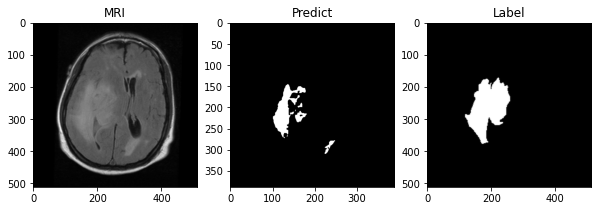

In [26]:
ckpt_path = './checkpoints/unet_medical_adam-1_3.ckpt'
#ckpt_path = fixme_3
test_net(data_dir=data_url, ckpt_path=ckpt_path, cross_valid_ind=cfg_unet['cross_valid_ind'],
         cfg=cfg_unet)

## 3. 实验任务

### 3.1 实验任务

请完成1.7节的程序，在'FIXME'位置填写正确内容，以保证程序正确运行。

## 4.小结

1. 了解U-net网络的相关知识
2. 掌握了如何进行数据增强
3. 定义复杂的网络结构